# CellRank meets pseudotime

In this tutorial, you will learn how to...
- compute a pseudotime using <cite data-cite="haghverdi:16">Diffusion pseudotime (DPT)</cite>
- set up CellRank's `PseudotimeKernel` to compute a transition matrix based on *any* pseudotime of your liking. 
- visualize the transition matrix in a low-dimensional embedding. 

Along the way, we'll see an example where RNA velocity does not work well; this motivates us to use the `PseudotimeKernel`. 

We can summarize the workflow, from a pseudotime up to the transition matrix, in the following figure: 

<img src="_static/img/pseudotime_kernel.jpg" width=800  alt="CellRank computes a transition matrix based on any pseudotime.">

We infuse directionality into a KNN graph using any pseudotime; edges that point into the pseudotemporal "past" are donw-weighted. This can be understood as an adapted, soft version of the <cite data-cite="setty:19">Palantir algorithm</cite>. 

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of <cite data-cite="setty:19">human bone marrow</cite>. If you want to run this on your own data, you will need...
- a scRNA-seq dataset for which you have computed a pseudotime using a tool like <cite data-cite="haghverdi:16">DPT</cite>, <cite data-cite="setty:19">Palantir</cite> or [Slingshot](https://bioconductor.org/packages/devel/bioc/vignettes/slingshot/inst/doc/vignette.html). 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/cellrank_meets_pseudotime.ipynb).

## Import packages & data

Check whether we are on google collab. 

In [13]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev
    !pip install python-igraph

Import packages, set verbosity levels. 

In [14]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Filter some warnings. 

In [15]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

First, we need to get the data. The following commands downloads the `adata` object and saves it under `datasets/setty_bone_marrow.h5ad`. We visualize the fraction of spliced/unspliced reads; these are required to estimate RNA velocity. 

In [16]:
adata = sc.read('datasets/ML_2022-06-09_raw_with_annotations_clean.h5ad')
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Check RNA velocity on this data

Before diving into the actual `PseudotimeKernel` we're exploring in this tutorial, let's motivate this choice a bit. We've seen that RNA velocity works well across a range of datasets including the pancres data from the [Cellrank meets RNA velocity](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_velocity.html) tutorial; so let's check how RNA velocity performs on this dataset. 

We'll check the ratio of spliced to unspliced counts, go through some basic preprocessing, run scVelo, compute a transition matrix using the `VelocityKernel` and visualize it. To learn more about these steps, please see the [Cellrank meets RNA velocity](https://cellrank.readthedocs.io/en/stable/cellrank_meets_rna_velocity.html) tutorial. 

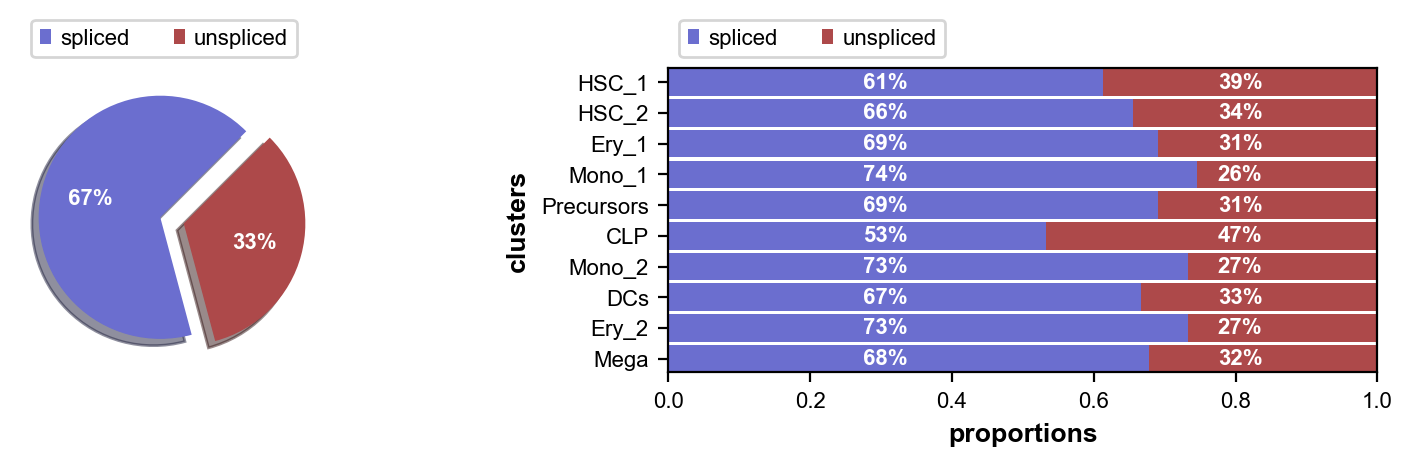

In [29]:
scv.pl.proportions(adata)

This looks fine. Next, filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. These are standard scanpy/scvelo functions, for more information about them, see the [scVelo API](https://scvelo.readthedocs.io/api.html#preprocessing-pp).

In [30]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 75 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Use the [dynamical model](https://scvelo.readthedocs.io/DynamicalModeling.html) from scVelo to estimate model parameters and compute velocities. On my MacBook using 8 cores, the below cell takes about 2 min to execute. 

In [21]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")

recovering dynamics (using 8/8 cores)



    finished (0:01:57) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Set up the `VelocityKernel` from the `adata` object containing the scVelo-computed velocities and compute a cell-cell transition matrix. 

In [23]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

Visualize via stream lines an a t-SNE embedding:  

Using precomputed projection `adata.obsm['T_fwd_tsne']`


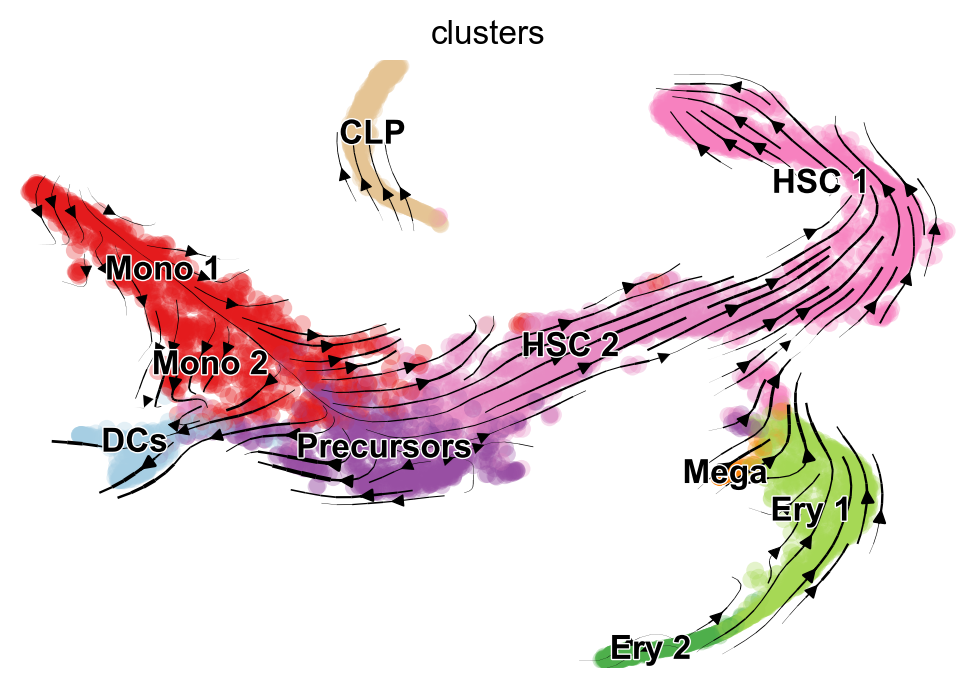

In [31]:
vk.plot_projection(basis='tsne')

That's a bit concerning, arrows point **exactly opposite** the known <cite data-cite="setty:19">differentiation trajectory</cite> in which hematopoietic stems cells (HSCs) differentiate via intermediate states towards Monocyotes (Mono), Dendritic cells (DCs), etc. That's not just a result of the low-dimensional representation, feel free to use CellRank to compute initial and terminal states on this data (see our [initial & terminal states](https://cellrank.readthedocs.io/en/stable/initial_terminal.html) tutorial) and you'll find them to be inconsistend with biological knowledge as well. 

To explore why this may be the case, let's look into the most influential genes driving the velocity flow here: 

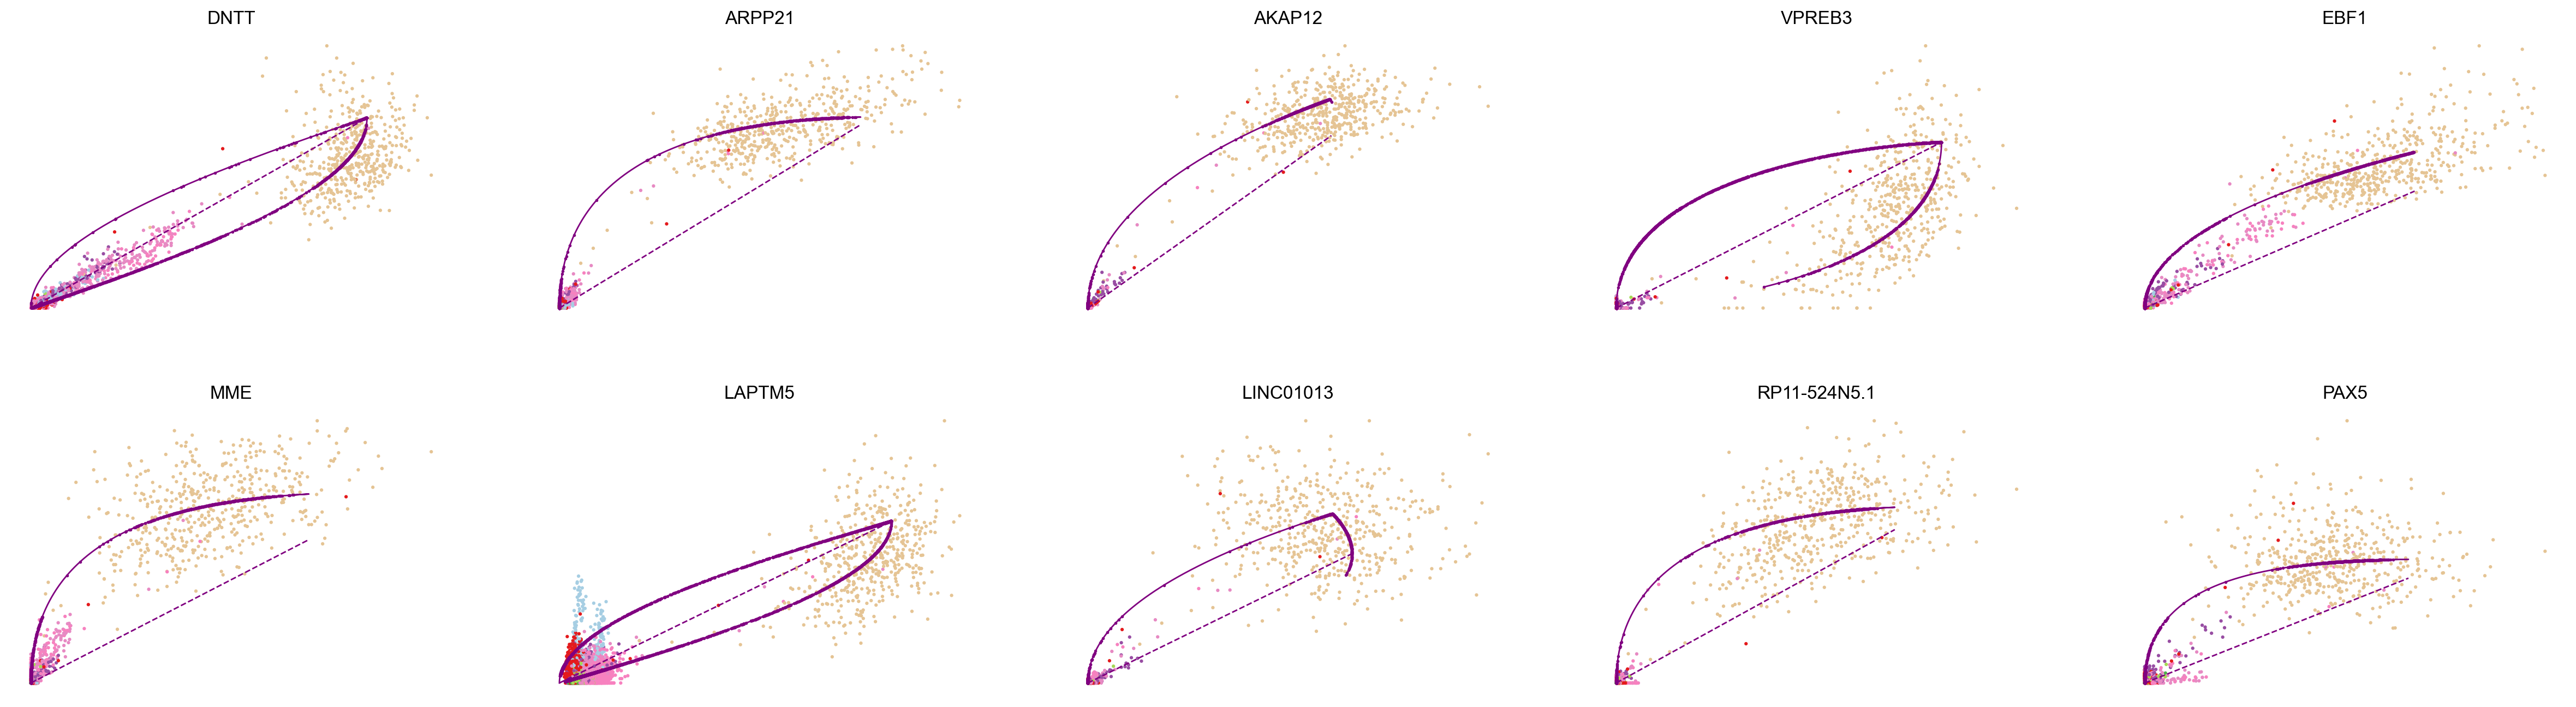

In [33]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:10], ncols=5, frameon=False)

In all of the top likelihood genes, the common lymphoid progenitor cells (CLPs) are a massive outlier! Since the current scVelo model does not account for state-dependent kinetic parmeters, this means the CLPs bias the parameter values for all other cells. We explored what happens if we remove CLPs and re-run the above analysis steps: 

<img src="_static/img/bm_driver_genes.jpg"   
alt="CellRank computes a transition matrix based on any pseudotime.">

Even with CLPs removed, projected velocities still point oppposite to what's known. The top-likelihood genes look different now - the CLP outliers have been removed; however, many of these top-influential genes show signs of state and time-dependent kinetic parameters. For example, in *ANK1*, Erythroid cells seem to require their own parameter set and in *RPS16*, the direction is inverted, i.e., an up-regulation is detected as a down-regulation, probably due to <cite data-cite="bergen:21, barile:21">transcriptional bursting</cite>. 

There's an easy way in CellRank to overcome these difficulties - use another kernel! In this tutorial, we'll use the `PseudotimeKernel` because hematopoiesis is a well-studied system where traditional pseutodime methods work well. 

## Choosing the right pseudotime

There's <cite data-cite="saelens:19">a lot</cite> of pseudotime algorithms out there, so how do you choose the right one for your data? We'll do a very superficial analysis here and just compare two methods: <cite data-cite="haghverdi:16">diffusion pseudotime (DPT)</cite> and the <cite data-cite="setty:19">Palantir pseudotime</cite>. 

The Palantir pseudotime has been precomputed for this dataset, check the [original tutorial](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) and the [scanpy interface](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.tl.palantir.html#scanpy.external.tl.palantir) to learn how to do this. To compute DPT on this dataset, we'll start by computing a <cite data-cite="coifman:05, haghverdi:15">diffusion map<\cite>. Feel free to check out [scanpy tutorials](https://scanpy.readthedocs.io/en/latest/tutorials.html), in particular the [PAGA tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html), to learn more. 

In [35]:
sc.tl.diffmap(adata)

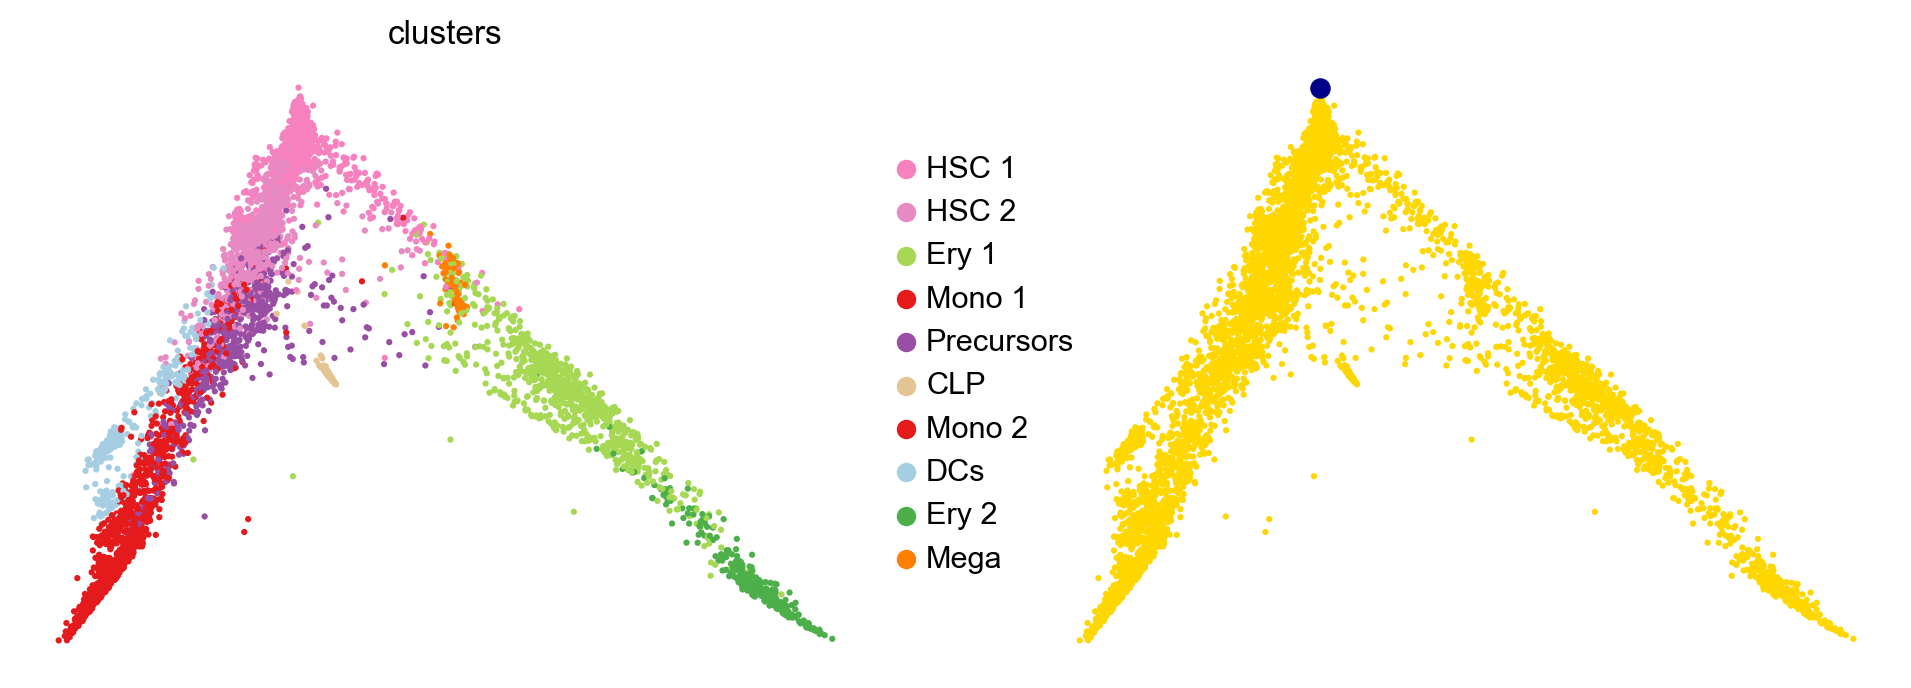

In [54]:
root_ixs = 2394 # has been found using `adata.obsm['X_diffmap'][:, 3].argmax()`
scv.pl.scatter(adata, basis='diffmap', c=['clusters', root_ixs], legend_loc='right', components=['2, 3'])

adata.uns['iroot'] = root_ixs

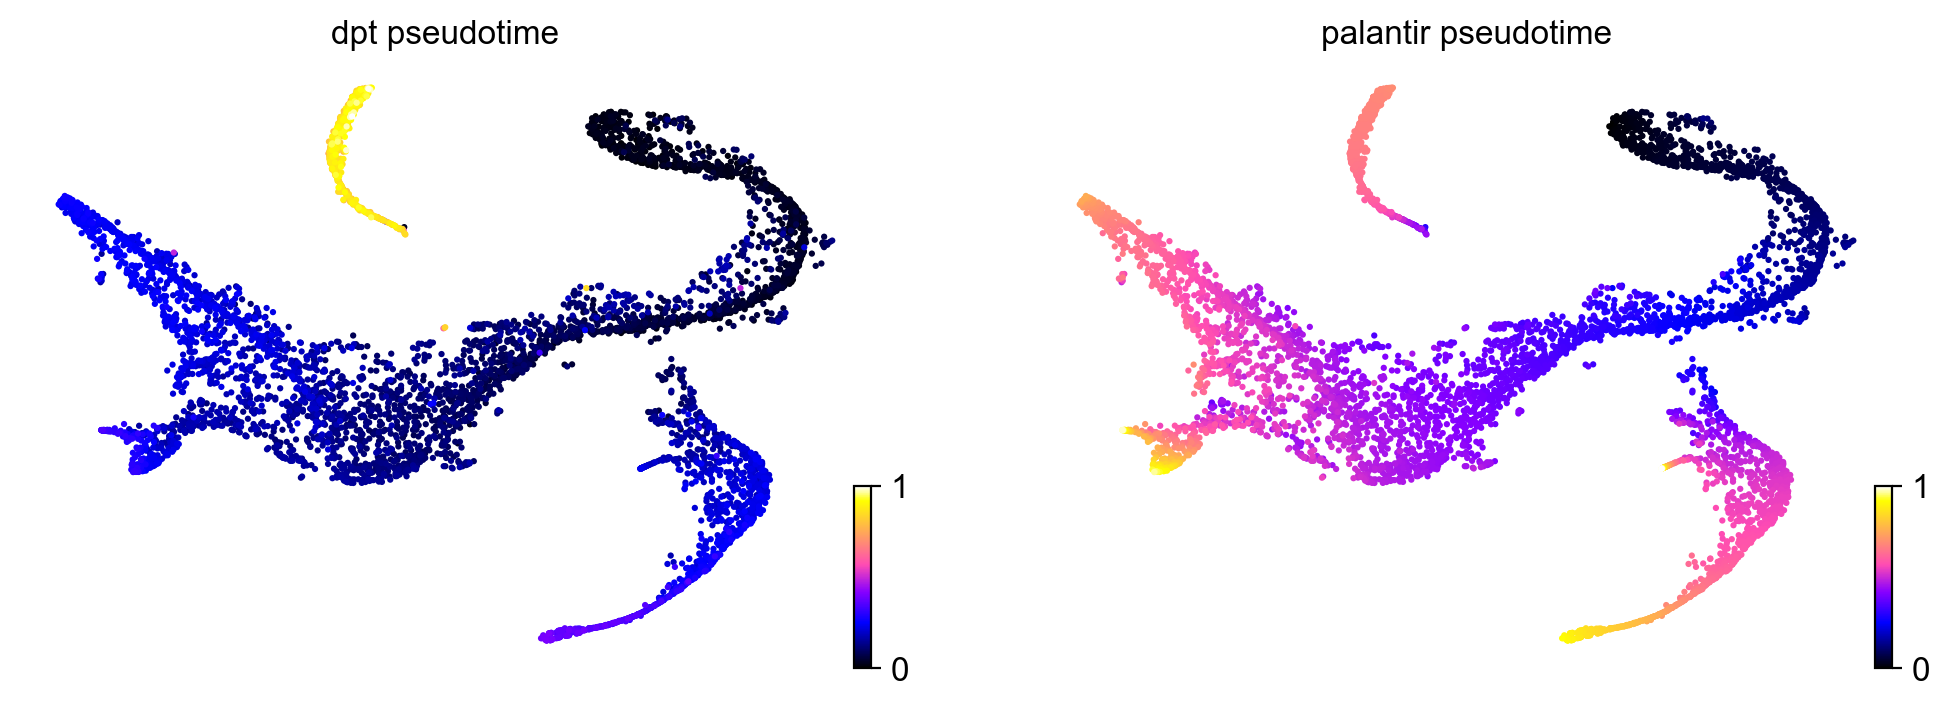

In [59]:
sc.tl.dpt(adata)
scv.pl.scatter(adata, basis='tsne', color=['dpt_pseudotime', 'palantir_pseudotime'], color_map='gnuplot2')

## What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix using RNA velocity and gene expression similarity and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...
- going through the [initial & terminal states tutorial](https://cellrank.readthedocs.io/en/stable/initial_terminal.html) to learn how to use the transition matrix to automatically identify initial and terminal states. 
- reading the <cite data-cite="lange:22">CellRank for directed single-cell fate mapping</cite> to learn more about the methods we used here. 
- taking a look at the [full API](https://cellrank.readthedocs.io/en/stable/api.html) to learn about parameter values you can use to adapt these computations to your data. 

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/). 

## Package versions

We used the following package versions to generate this tutorial: 

In [14]:
cr.logging.print_versions()

cellrank==1.5.1+g65f1562 scanpy==1.7.2 anndata==0.8.0 numpy==1.21.4 numba==0.51.2 scipy==1.5.3 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.3.3 seaborn==0.11.0
